In [230]:
#!pip install geopandas

In [231]:
#!pip install folium

In [232]:
import numpy as np
import pandas as pd
import geopandas as gpd ## extension panda pour gérer des données géographiques
import folium ## permet de créer des cartes interactives
import requests ## pour faire des requêtes HTTP pour récupérer des données en ligne
from matplotlib import pyplot as plt ## partie de la bibliothèque Matplotlib utilisée pour faire des graphiques.
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler ## onctions de SciPy pour faire du clustering hiérarchique 
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
from shapely.geometry import Point ## Shapely est une bibliothèque Python utilisée pour manipuler des objets géométriques (points, lignes, polygones) dans un contexte géospatial.
from traitement_donnees import *
from dataFrameUtil import *

In [233]:
import importlib
import traitement_donnees
importlib.reload(traitement_donnees)
from traitement_donnees import *

import dataFrameUtil
importlib.reload(dataFrameUtil)
from dataFrameUtil import *

# Partie 1 : Nettoyage et fusion des bases des données

## Ouverture des bases et premiers nettoyages

### Ouverture des bases de données

In [234]:
revenus = getRevenus()

### Recodage des variables

 Ici on nettoie les noms des colonnes du DataFrame en supprimant certains préfixes et suffixes spécifiques, et en convertissant tous les noms de colonnes en minuscules pour une meilleure lisibilité et cohérence. Ainsi on retir le préfixe "DISP_" et le suffixe "18" des noms de colonnes. Ce préfixe et ce suffixe se retrouvent en effet dans l'ensemble des noms de colonnes et permet à l'INSEE de distinguer différente base (notamment la base des revenus disponibles de la base des revenus déclarés, et ici le 18 spécifie que ce sont les données de 2018). Comme nous utilisons uniquement la base des revenus disponibles de 2018, ces renseignements ne sont pas nécessaires. Ensuite, on convertit tous les noms en minuscules. Enfin, on affiche les nouveaux noms de colonnes.

De la même manière, on simplifie le nom des colonnes de la base de données sur la démographie de chaque quartier.

### Réduire "df"" aux colonnes nécessaires

## Synthétiser les données de la base "revenu"

### Nettoyage et préparation des données

In [235]:
revenus.head()
## (info à mettre dans le read_me) Ce tableau statistique de l'INSEE contient une colonne d'indentification géographique (IRIS) et de nombreuses colonnes de variables sur les revenus (médiane, déciles, quartiles, indices d’inégalité, parts de prestations, impôts, etc.) 

,iris,tp60,q1,med,q3,eq,d1,d2,d3,d4,...,pcho,pben,ppen,ppat,ppsoc,ppfam,ppmini,pplogt,pimpot,note
0,010040101,20.1,14000.0,19300.0,25250.0,0.58,10340.0,13010.0,14970.0,17020.0,...,3.0,2.7,27.7,7.3,8.8,3.4,3.4,2.0,-15.1,0
1,010040102,25.7,12890.0,17530.0,23100.0,0.58,9970.0,12030.0,13710.0,15570.0,...,4.2,2.2,26.2,6.6,11.5,3.9,4.5,3.1,-13.8,0
2,010040201,19.1,14090.0,19580.0,26320.0,0.62,11000.0,13140.0,15170.0,17640.0,...,3.1,4.2,28.9,8.2,7.8,3.1,2.6,2.1,-15.8,0
3,010040202,8.9,18360.0,24530.0,31590.0,0.54,13600.0,17120.0,19550.0,21970.0,...,2.3,3.6,23.6,21.2,4.1,2.1,1.2,0.8,-20.3,0
4,010330102,18.6,14060.0,19960.0,28100.0,0.70,10230.0,13330.0,15420.0,17470.0,...,4.2,2.4,26.7,8.4,5.2,1.6,2.0,1.6,-14.7,0


Ajouter ici un texte pour expliquer pourquoi on fait une CAH : quel intérêt pour la suite de notre analyse ?
- trop de variables à analyser = les regrouper
- interactions entre les variables = profil économique plus complet
- voir des relations non linéaires
- avoir une variable catégorielle = ça peut être utile pour la visualisation de données, notamment pour la carto

CAH (Clustering Ascendant Hiérarchique)
Faire un indice synthétique pour pouvoir représenter facilement les caractéristiques structurelles des quartiers sur une carte

In [236]:
print(revenus.shape)
revenus.isna().sum()

(12395, 29)


iris         0
tp60      2881
q1           1
med          1
q3           1
eq           1
d1           1
d2           1
d3           1
d4           1
d6           1
d7           1
d8           1
d9           1
rd           1
s80s20       1
gi           1
pact         1
ptsa       440
pcho       440
pben       440
ppen         1
ppat         1
ppsoc        1
ppfam        1
ppmini       1
pplogt       1
pimpot       1
note         0
dtype: int64

Cette étape nous permet de repérer que la colonne tp60 (taux de pauvreté) contient un nombre important de valeurs manquantes (presque un quart des quartiers). Nous retirerons cette colonne pour notre CAH. Les autres colonnes contiennent toutes un nombre relativement faible de valeurs manquantes. On imputera une valeur (la médiane) à la place de ces valeurs manquantes.

Certaines colonnes doivent aussi être retirées pour réaliser la CAH, notamment la colonne "iris", qui contient le code de l'IRIS et n'indique rien sur le profil économique du quartier, de même que la variable "note" qui donne de l'information sur la qualité des données et non sur le profil économique du quartier.

En raison de la forte redondance entre les différentes variables sur le revenu disponible qui pourraient effacer le rôle des inégalités de revenu lors de l'analyse, nous enlèverons également une partie des données sur les revenus des différents déciles. Nous garderons tout de même les revenus des déciles 1, 5 et 9 et des quartiles 1 et 3.

In [237]:
rev_cah = getRevenusCah(revenus)

Les variables ont été standardisées afin d’éviter qu’une dimension domine la classification hiérarchique.

### Réalisation d'une CAH

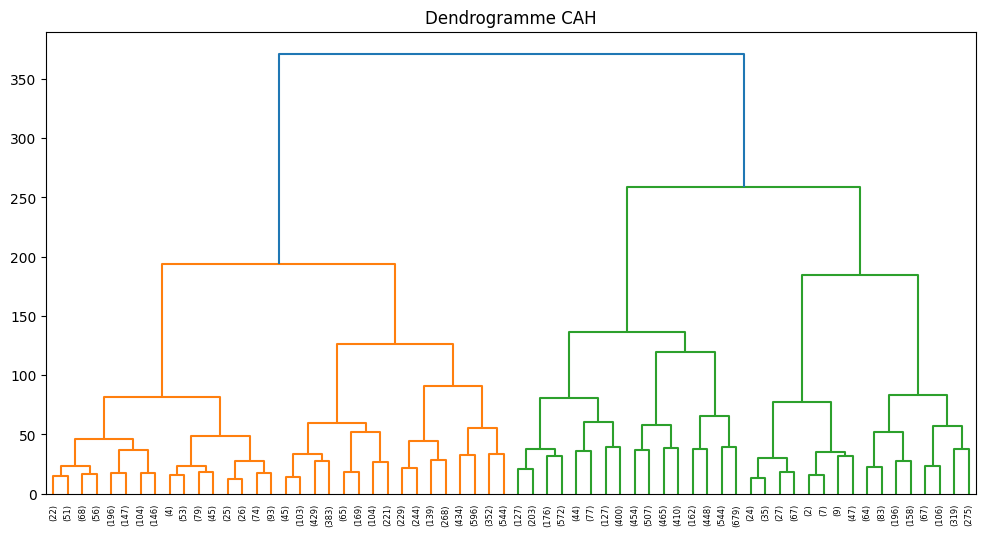

In [238]:
# CAH
cah = doCAH(rev_cah)

plotDendrogramme(cah)

Pour notre analyse, nous avons besoin d'un nombre suffisamment grand de cluster pour identifier différents types de cluster (minimum 4), mais pas trop important pour ne pas trop compliquer l'analyse. Pour déterminer combien de cluster garder, nous utilisons la méthode du coude.

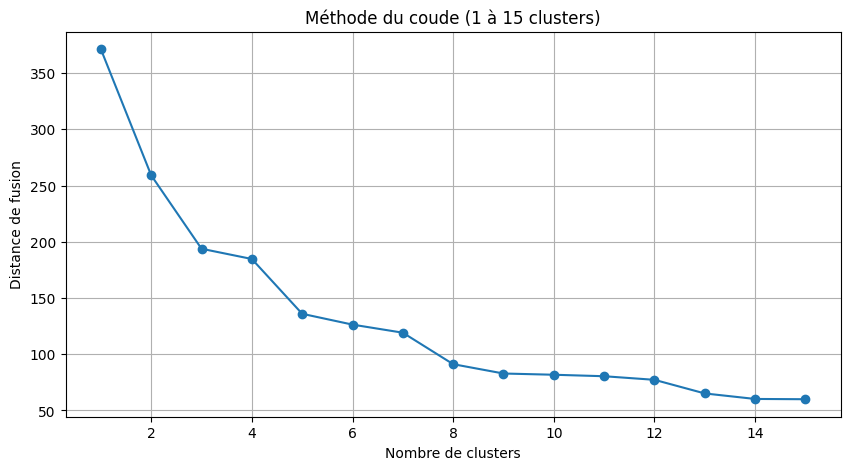

In [239]:
plotCoude(cah)

On utilise la distance des fusions pour tracer une courbe et identifier le “coude”, c’est-à-dire le nombre de clusters où fusionner davantage devient peu utile.

Conserver 5 clusters plutôt que 4 permet de conserver plus d'informations, mais entre 5 et 7 clusters, la distance de fusion est proche. Garder 8 clusters nous semble un nombre trop important pour notre analyse. Nous avons donc décidé de conserver 5 clusters.

In [240]:
# Découpage en clusters
createClusters(revenus, cah)

summary_with_total = analyzeClusters(revenus)

print(summary_with_total.to_string())


            tp60           med            q1            q3        rd        gi       pact       ptsa      pcho       pben       ppen       ppat      ppsoc     ppmini     pimpot
1      46.129526  13728.637511  10465.189235  18489.798150  2.953070  0.246938  56.888394  50.447423  5.522474   2.334021  24.473507   3.586964  24.838772  11.656266  -9.787637
2      25.916356  18086.376879  13074.520231  24545.553757  3.351561  0.267412  73.010289  65.868232  4.113500   3.378691  25.208555   5.688393  11.068231   4.583121 -14.975468
3      13.514797  23488.464961  17320.986281  31347.951428  3.363033  0.275404  73.844123  65.508333  2.766741   5.602710  30.457249  10.537227   4.687968   1.816963 -19.526567
4      10.473913  43935.458716  25572.660550  73296.559633  8.648165  0.502436  84.733945  69.787615  1.683945  13.262385  18.461468  34.336239   0.812844   0.320183 -38.344495
5      11.989292  32169.834385  21913.257098  45705.402208  4.554968  0.332588  91.388644  82.440379  2.578233   6.

Il s'agit ici d'analyser la manière dont les quartiers ont été regroupés au sein de chaque clusters. On observe la moyenne de certaines variables pour effectuer cette analyse : 
- le taux de pauvreté
- des indicateurs sur le revenu : médiane (med), quartile 1 (q1) et quartile 3 (q3)
- des indicateurs sur les inégalités : rapport interdéciles (rd) et indice de gini (gi)
- la part des revenus d'activité dans le revenu disponible (pact)
- la part des salaires et traitements dans les revenus d'activité (ptsa), dont la part des indemnités de chômage dans les revenus d'activité (pcho), la part des revenus des activités non salariées dans les revenus d'activité (pben) et la part des pensions, retraites et rentes dans les revenus d'activités (ppen) 
- la part des revenus du patrimoine dans le revenu disponible (ppat)
- la part des prestations sociales dans le revenu disponible (ppsoc) dont la part des minima sociaux dans les prestations sociales (ppmini).

En termes de salaire, on observe qu'aussi bien pour le revenu médian que les revenus des quartiles 1 et 3, l'ordre des quartiers des plus pauvres au plus riche et le suivant : 1, 2, 3, 5, 4. On retrouve ce même ordre concernant le taux de pauvreté, la part des revenus du patrimoine, des prestations sociales, des minima sociaux et des impôts.

Ce qui rapproche le cluster 4 du cluster 3 et qui pourrait expliquer pourquoi l'ordre des clusters 4 et 5 n'est pas inversé, ce sont les variables sur la part des revenus d'activité dans le revenu disponible et la part des salaires et traitements dans les revenus d'activité. Cependant, lorsque l'on analyse les autres sources de revenus, on remarque que cette proximité du taux des revenus d'activité s'explique différemment. Le niveau plus faible de la part des revenus d'activité des quartiers du cluster 4 s'explique part l'importance des revenus du patrimoine, ce qui n'est pas le cas des quartiers du cluster 3. Similairement, la part moins importante des traitements et salaires dans les revenus d'activité des quartiers du cluster 4 tiennent en partie à la place importante des revenus des activités non salariés, contrairement aux quartiers du cluster 3 pour lesquels ces revenus n'ont pas une place importante.

Ces différentes observations nous permettent de conclure que, même si les quartiers du cluster 4 sont plus proches selon la CAH des quartiers 3 que les quartiers 5, on peut tout de même analyser les clusters selon le niveau de richesse des quartiers, dans l'ordre établi précédemment (1, 2, 3, 5, 4).
Cela correspondant également aux inégalités au sein des quartiers : les clusters avec des quartiers plus pauvres sont aussi les clusters avec des quartiers plus inégalitaires et réciproquement.

In [241]:
renameClusters(revenus)

# nombre de quartiers par clusters
print(revenus["cluster_label"].value_counts())

cluster_label
moyen          5395
pauvre         4325
riche          1268
tres_pauvre    1189
tres_riche      218
Name: count, dtype: int64


Les clusters "très riches" sont les moins nombreux, ce qui semble assez cohérent avec différentes analyses sur le décrochage des très hauts revenus et qui peuvent se retrouver au niveau des quartiers (cette explication est peut-être bancale).

Les quartiers "moyens" sont les plus nombreux. Comme ils se situent au milieu concernant les données et qu'ils sont les plus nombreux, ils serviront de référence lors des différentes analyses qui nécessitent une modalité de référence.

## Fusion des bases

### Fusion de "gdf_iris" et "revenus"

In [242]:
iris = getIris(revenus)

c:\Users\Utilisateur\Desktop\cours\python\projet_python\traitement_donnees.py:51: DtypeWarning: Columns (0,1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  population = pd.read_csv("data/population.csv", sep=";")


In [243]:
iris[["cluster_label", "pop"]].head()

,cluster_label,pop
0,NaN,46.284946
1,tres_pauvre,1399.029222
2,NaN,0.000000
3,NaN,733.892021
4,NaN,14.625455


Lorsqu'on ajoute les données de la base "revenus" à celle de la base "gdf_iris", on obtient un grand nombre de valeurs manquantes, qui tient au fait que la base "gdf_iris" contient un plus grand nombre de lignes que la base "revenus". Les données sur les revenus des IRIS ne sont pas disponibles pour l'ensemble des IRIS, probablement parce que certains IRIS ont trop peu d'habitants pour que les données sur les revenus soient ouvertes en raison de la protection des données individuelles. On peut vérifier si cette hypothèse semble vérifier en regardant pour quels types d'IRIS on a le plus de valeurs manquantes.

In [244]:
print(iris["type_iris_label"].value_counts())
pd.crosstab(iris["type_iris"], iris["cluster_label"], normalize="index", dropna=False)

type_iris_label
autre       32941
habitat     14431
activité      819
divers        321
Name: count, dtype: int64


cluster_label,moyen,pauvre,riche,tres_pauvre,tres_riche,NaN
type_iris,,,,,,
A,0.056166,0.053724,0.007326,0.007326,0.009768,0.865690
D,0.118380,0.031153,0.012461,0.000000,0.000000,0.838006
H,0.365255,0.284526,0.086966,0.069434,0.014552,0.179267
Z,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


On remarque que les iris de type "Z" ("autres") n'ont pas de valeurs, de même que la plupart des iris "A" ("activité") et D ("divers" : il s'agit de grandes zones spécifiques peu habitées et ayant une superficie importante (parcs de loisirs, zones portuaires, forêts, ...).), mais les IRIS H ("habitat") ont presque tous des valeurs concernant les revenus des habitants. Les données de l'INSEE disponibles concernent probablement seulement les quartiers qui ont beaucoup d'habitants pour des raisons de protection des données personnelles. Pour qu'on puisse utiliser ces données par la suite, il faudra vérifier que les formations post-bac se trouvent majoritairement dans des quartiers pour lesquelles ces données sont disponibles.

### Fusion de "gdf_iris" et "population"

Lorsqu'on essaie de fusionner directement les fichiers "population" et "gdf_iris", de nombreuses lignes n'arrivent pas à être fusionnées. En passant par les données "meta" de la base "population", la fusion fonctionne mieux. On commence donc par récupérer les codes iris présents dans les données "meta".

On peut désormais fusionner les bases "gdf_iris" et "population" en utilisant la variable "COD_MOD".

In [245]:
iris.groupby("type_iris_label")["pop"].apply(lambda x: x.isna().sum())

type_iris_label
activité      21
autre       3053
divers        17
habitat      735
Name: pop, dtype: int64

Encore une fois, ce sont principalement les iris "autres" qui ont souvent pas de données. On n'a pas de correspondance parfaite non plus pour les autres, probablement en raison des changements des IRIS entre les différentes bases de données selon l'année de référence, mais les tables de passage des codes IRIS ne sont pas disponibles pour les années récentes.

### Fusion de "df" (parcoursup) et "gdf_iris"

In [246]:
parcoursup_total = getParcoursup(iris)

In [247]:
# vérifications
print(parcoursup_total.isna()[["code_iris", "cluster_label", "pop"]].sum())
print(parcoursup_total.shape)

code_iris         762
cluster_label    3249
pop              1303
dtype: int64
(14079, 52)


762 formations n'ont pas été associées à des IRIS. Cela tient probablement au fait qu'une partie des formations de parcoursup ne se trouvent pas en France.

La plupart des formations ont des données sur socio-démographiques sur leur quartier. 3249 formations sur les 14079 n'ont pas de données sur le profil économique du quartier. On a donc ces données pour 77% des formations, ce qui est suffisant pour mener des analyses.

# Partie 2 : L'inégale mobilité des étudiants lors de l'entrée dans les études supérieures

In [248]:
parcoursup_total.groupby("part_memeac2_decile")["admis_boursier"].mean()

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_27156\1305191424.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  parcoursup_total.groupby("part_memeac2_decile")["admis_boursier"].mean()


part_memeac2_decile
Q1     18.108696
Q2     22.355093
Q3     23.423322
Q4     25.455192
Q5     25.561828
Q6     27.280778
Q7     28.814371
Q8     29.820461
Q9     30.218796
Q10    28.696970
Name: admis_boursier, dtype: float64

c:\Users\Utilisateur\Desktop\cours\python\projet_python\traitement_donnees.py:165: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("part_memeac2_decile")["admis_boursier"]


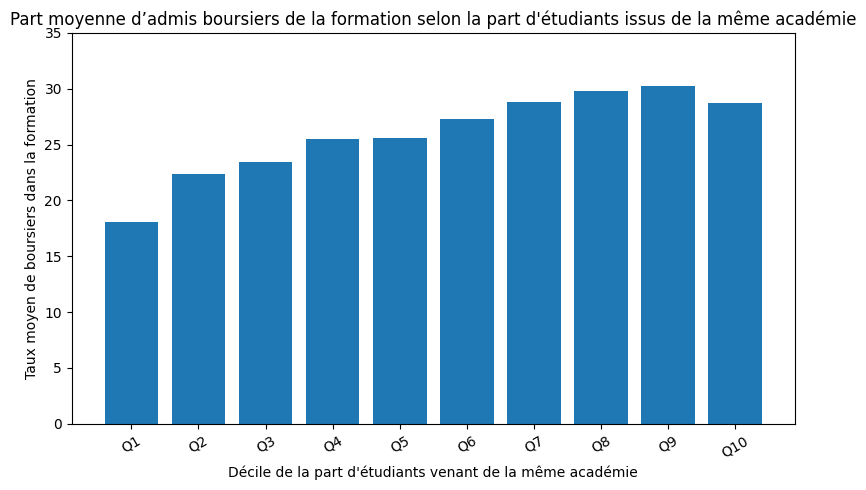

In [249]:
plotParcoursupMobilitesBoursiers(parcoursup_total)

In [250]:
parcoursup_xy = parcoursup_total[["admis_boursier", "part_memeac2"]].dropna()
pearsonr(parcoursup_xy["admis_boursier"], parcoursup_xy["part_memeac2"])

PearsonRResult(statistic=np.float64(0.17476538824548773), pvalue=np.float64(5.920938532282529e-97))

Les formations qui sont les plus "locales" (i.e. qui attirent beaucoup d'étudiants de leur académie) sont aussi celles qui contiennent le plus grand nombre de boursiers. Cela peut être lié au fait que les boursiers vont plus souvent dans des formations proches car ils ont moins les moyens financiers d'avoir leur propre logement et donc d'aller dans des formations éloignées. Dès lors, il apparaît comme particulièrement important d'étudier la localisation des formations puisque la mobilité des étudiants n'est pas identique selon leurs profils socio-économiques. Ainsi, la répartition géographique des formations n'est pas neutre et a un effet sur l'accès aux formations. Il semble donc particulièrement important de s'intéresser aux mécanismes qui expliquent les lieux où se trouvent les formations pour analyser si l'offre de formation est la même pour tous les étudiants post-bac.

# Partie 3 : Où se trouvent les formations ?

## 3.1. Création d'une variable sur le nombre de formations par IRIS

In [251]:
iris = updateIris(iris, parcoursup_total)

In [ ]:
iris[NB_FORMATIONS].head()

KeyError: 'has_formation'

In [ ]:
print(iris[NB_FORMATIONS].value_counts(dropna=False))

KeyError: 'nb_formations'

## 3.2. Quartiers qui ont une formation selon leur profil économique

In [ ]:
# =====================================================
# 1) Préparer les IRIS – France métropolitaine uniquement
# =====================================================
gdf_iris = gdf_iris.copy()

gdf_iris["code_iris"] = gdf_iris["code_iris"].astype(str)
gdf_iris["code_dept"] = gdf_iris["code_iris"].str[:2]

deps_metro = (
    [f"{i:02d}" for i in range(1, 96)]
    + ["2A", "2B"]
)

gdf_metro = gdf_iris[gdf_iris["code_dept"].isin(deps_metro)].copy()

print("Nombre d'IRIS en France métropolitaine :", gdf_metro.shape[0])

# Sécurisation JSON (important pour Folium)
for col in gdf_metro.columns:
    if isinstance(gdf_metro[col].dtype, (pd.CategoricalDtype, pd.IntervalDtype)):
        gdf_metro[col] = gdf_metro[col].astype(str)

# =====================================================
# 2) Filtrer les formations situées en France métropolitaine
# =====================================================
metro_iris_codes = set(gdf_metro["code_iris"])

df_points_metro = df_total[
    df_total["code_iris"].astype(str).isin(metro_iris_codes)
].dropna(subset=["latitude", "longitude"]).copy()

print("Nombre de formations en France métropolitaine :", df_points_metro.shape[0])

# =====================================================
# 3) Palette de couleurs pour les quartiers
# =====================================================
cluster_colors = {
    "tres_pauvre": "#b30000",
    "pauvre":      "#fc8d59",
    "moyen":       "#fee08b",
    "riche":       "#91bfdb",
    "tres_riche":  "#4575b4",
}

def style_cluster(feature):
    label = feature["properties"].get("cluster_label")
    return {
        "fillColor": cluster_colors.get(label, "#cccccc"),
        "color": "black",
        "weight": 0.3,
        "fillOpacity": 0.6,
    }

# =====================================================
# 4) Créer la carte – France entière
# =====================================================

m = folium.Map(
    location=[46.6, 2.5],  # centre France
    zoom_start=6,
    min_zoom=5,            # empêche le dézoom au-delà de la France
    max_zoom=13,
    zoomControl=True
)

# =====================================================
# 5) Ajouter les polygones IRIS
# =====================================================
folium.GeoJson(
    gdf_metro,
    name="Quartiers (IRIS)",
    style_function=style_cluster,
    tooltip=folium.GeoJsonTooltip(
        fields=["nom_iris", "nom_commune", "cluster_label"],
        aliases=["IRIS", "Commune", "Type de quartier"],
        localize=True
    ),
).add_to(m)

# =====================================================
# 6) Ajouter les formations
# =====================================================
for _, row in df_points_metro.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=2,
        color="darkred",
        fill=True,
        fill_opacity=0.8,
    ).add_to(m)

# =====================================================
# 7) Contrôles et affichage
# =====================================================
folium.LayerControl().add_to(m)
#m


In [ ]:
pd.crosstab(gdf_iris["cluster_label"], gdf_iris["has_formation"], normalize="index", dropna=False)

## 3.3 Quartiers qui ont une formation selon leur profil démographique

In [ ]:
bins = range(0, 5000, 100)

gdf_iris["pop_bin"] = pd.cut(
    gdf_iris["pop"],
    bins=bins,
    include_lowest=True,
    right=False
)

prop = (
    gdf_iris
    .groupby("pop_bin")["has_formation"]
    .mean()
    .reset_index()
)

prop["bin_center"] = prop["pop_bin"].apply(lambda x: x.mid)

plt.figure(figsize=(10,5))
plt.plot(prop["bin_center"], prop["has_formation"], marker="o")
plt.xlabel("Nombre d'habitants")
plt.ylabel("Proportion de formations")

Plus il y a d'habitants dans un quartier, plus la probabilité qu'il y ait une formation semble élevée. Cette probabilité augemente particulièrement entre 1000 et 3000 habitants : elle est très faible avant 1000 habitants et est difficile à interpréter pour les quartiers au-delà de 3000 habitants en raison de leur faible nombre.

In [ ]:
# construire des variables : part des 11-17 ans
gdf_iris["part1117"] = (gdf_iris["pop1117"] / gdf_iris["pop"]) * 100
gdf_iris["part1824"] = (gdf_iris["pop1824"] / gdf_iris["pop"]) * 100
gdf_iris["part60p"] = ((gdf_iris["pop6074"] + gdf_iris["pop75p"])/ gdf_iris["pop"]) * 100

In [ ]:
bins = range(0, 30, 2)

gdf_iris["part1824_bin"] = pd.cut(
    gdf_iris["part1824"],
    bins=bins,
    include_lowest=True,
    right=False
)

prop = (
    gdf_iris
    .groupby("part1824_bin")["has_formation"]
    .mean()
    .reset_index()
)

prop["bin_center"] = prop["part1824_bin"].apply(lambda x: x.mid)

plt.figure(figsize=(10,5))
plt.plot(prop["bin_center"], prop["has_formation"], marker="o")
plt.xlabel("Part des 18-24 ans (%)")
plt.ylabel("Probabilité d'avoir une formations")
plt.title("Probabité d'avoir une formation selon la part des 18-24 ans")
plt.grid(True)
plt.show()

In [ ]:
bins = range(0, 30, 2)

gdf_iris["part1117_bin"] = pd.cut(
    gdf_iris["part1117"],
    bins=bins,
    include_lowest=True,
    right=False
)

prop = (
    gdf_iris
    .groupby("part1117_bin")["has_formation"]
    .mean()
    .reset_index()
)

prop["bin_center"] = prop["part1117_bin"].apply(lambda x: x.mid)

plt.figure(figsize=(10,5))
plt.plot(prop["bin_center"], prop["has_formation"], marker="o")
plt.xlabel("Part des 11–17 ans (%)")
plt.ylabel("Proportion de formations")
plt.title("Proportion de formations selon la part des 11–17 ans")
plt.grid(True)
plt.show()

Les quartiers avec beaucoup de jeunes (11-17 ans) sont souvent les quartiers les plus pauvres, qui sont ceux qui n'ont pas souvent de formations, ce qui explique pourquoi les formations ne se trouvent pas dans les quartiers avec beaucoup de jeunes.

Contrairement à ce à quoi on pourrait s'attendre, il n'y a pas plus de formation dans les quartiers avec beaucoup d'adolescentes (ici les 11 à 17 ans). En revanche, il y a plus de formations dans les quartiers avec beaucoup de jeunes 18-24 ans, probablement parce que ces quartiers attirent les 18-24 (et non pas parce que les formations sont localisées dans les quartiers où il y avait déjà beaucoup de jeunes).

## Modélisation de la probabilité qu'un quartier possède une formation

In [ ]:
#Construire un dataframe d'estimation propre : on garde uniquement les colonnes utiles au modèle.
# Ici, le coeur du modèle : C(cluster_label) et quelques contrôles démographiques/sociaux.
df_model = gdf_iris[["has_formation", "pop", "cluster_label", "type_iris_label"]].copy()

# Nettoyage : on enlève les lignes avec NA sur les variables du modèle
df_model = df_model.dropna()

print("Taille de l'échantillon :", df_model.shape)

In [ ]:
# Spécifier le modèle logit (formule)
# C(cluster_label) indique à statsmodels que cluster_label est catégorielle (dummies auto)
# La catégorie de référence est choisie automatiquement (souvent ordre alphabétique).
# imposer une référence 
terms = ["C(cluster_label, Treatment(reference='moyen'))", "C(type_iris_label, Treatment(reference='habitat'))", "pop"]

formula = "has_formation ~ " + " + ".join(terms)

In [ ]:
#Estimer le logit par maximum de vraisemblance

logit_model = smf.logit(formula=formula, data=df_model)
logit_results = logit_model.fit()

print("\nRésumé du logit :")
print(logit_results.summary())

# Partie 4 : Où se trouvent les formations sélectives ?

## Création d'une variable sur le nombre de formations sélectives par IRIS

In [ ]:
print(df_total["selectivite"].value_counts())
df_total["taux_acces"].quantile([0.25, 0.333, 0.5, 0.75])
(df_total["taux_acces"] < 50).mean()

In [ ]:
# créer les colonnes pour les formations très sélectives
df_total["tres_select"] = df_total["taux_acces"] < 50

# compter par IRIS
result = df_total.groupby("code_iris")[["tres_select"]].sum().reset_index()

# vérifier que ce n'est pas incohérent (il devrait y avoir moins de formations sélectives que de formations)
result2 = total_form.merge(result, on="code_iris", how="left")
result2.head()

In [ ]:
gdf_iris = gdf_iris.merge(result, on="code_iris", how="left")
gdf_iris["tres_select"] = gdf_iris["tres_select"].fillna(0)

In [ ]:
# Construire la variable dépendante binaire Y = has_selective
gdf_iris["has_selective"] = (gdf_iris["tres_select"] > 0).astype(int)

## Quartiers qui ont une formation selon leur profil économique

In [ ]:
# 1) Ajouter un code département à partir du code IRIS
gdf_iris["code_iris"] = gdf_iris["code_iris"].astype(str)
gdf_iris["code_dept"] = gdf_iris["code_iris"].str[:2]

# 2) Filtrer uniquement Paris (75)
idf_deps = ["75"]
gdf_idf = gdf_iris[gdf_iris["code_dept"].isin(idf_deps)].copy()
print("Nombre d'IRIS en région parisienne :", gdf_idf.shape[0])

# 3) Palette de couleurs pour les types de quartiers (clusters)
cluster_colors = {
    "tres_pauvre": "#b30000",
    "pauvre":      "#fc8d59",
    "moyen":       "#fee08b",
    "riche":       "#91bfdb",
    "tres_riche":  "#4575b4",
}

def style_cluster(feature):
    label = feature["properties"].get("cluster_label")
    color = cluster_colors.get(label, "#cccccc")  # gris si NaN
    return {
        "fillColor": color,
        "color": "black",
        "weight": 0.3,
        "fillOpacity": 0.6,
    }

# 4) Filtrer les formations qui sont dans un IRIS IDF
idf_iris_codes = set(gdf_idf["code_iris"].astype(str).unique())
df_points_idf = df_total[
    df_total["code_iris"].astype(str).isin(idf_iris_codes)
].dropna(subset=["latitude", "longitude"]).copy()

# 4b) Créer la colonne tres_select
df_points_idf["tres_select"] = df_points_idf["taux_acces"] < 50
df_points_idf["tres_select"] = df_points_idf["tres_select"].astype(bool)

print("Nombre de formations en IDF :", df_points_idf.shape[0])

# 5) Créer une carte centrée sur Paris
m = folium.Map(
    location=[48.8566, 2.3522],
    zoom_start=12,
    max_zoom=12,
    min_zoom=12,
    dragging=False,
    scrollWheelZoom=False,
    doubleClickZoom=False,
    zoomControl=False
)

# 6) Ajouter les polygones IRIS colorés selon le type de quartier
folium.GeoJson(
    gdf_idf,
    name="Quartiers (IRIS)",
    style_function=style_cluster,
    tooltip=folium.GeoJsonTooltip(
        fields=["nom_iris", "nom_commune", "cluster_label"],
        aliases=["IRIS", "Commune", "Type de quartier"],
        localize=True
    ),
).add_to(m)

# 7) Ajouter les formations en points
for _, row in df_points_idf.iterrows():
    color = "darkred" if row["tres_select"] else "red"
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=2,
        color=color,
        fill=True,
        fill_opacity=0.8,
    ).add_to(m)

# 8) Ajouter le LayerControl
folium.LayerControl().add_to(m)

# 9) Afficher la carte
m


In [ ]:
# 1) Ajouter un code département à partir du code IRIS
gdf_iris["code_iris"] = gdf_iris["code_iris"].astype(str)
gdf_iris["code_dept"] = gdf_iris["code_iris"].str[:2]

# 2) Filtrer uniquement Strasbourg (67)
idf_deps = ["67"]
gdf_idf = gdf_iris[gdf_iris["code_dept"].isin(idf_deps)].copy()
print("Nombre d'IRIS dans le Bas-Rhin :", gdf_idf.shape[0])

# 3) Palette de couleurs pour les types de quartiers (clusters)
cluster_colors = {
    "tres_pauvre": "#b30000",
    "pauvre":      "#fc8d59",
    "moyen":       "#fee08b",
    "riche":       "#91bfdb",
    "tres_riche":  "#4575b4",
}

def style_cluster(feature):
    label = feature["properties"].get("cluster_label")
    color = cluster_colors.get(label, "#cccccc")  # gris si NaN
    return {
        "fillColor": color,
        "color": "black",
        "weight": 0.3,
        "fillOpacity": 0.6,
    }

# 4) Filtrer les formations qui sont dans un IRIS IDF
idf_iris_codes = set(gdf_idf["code_iris"].astype(str).unique())
df_points_idf = df_total[
    df_total["code_iris"].astype(str).isin(idf_iris_codes)
].dropna(subset=["latitude", "longitude"]).copy()

# 4b) Créer la colonne tres_select
df_points_idf["tres_select"] = df_points_idf["taux_acces"] < 50
df_points_idf["tres_select"] = df_points_idf["tres_select"].astype(bool)

print("Nombre de formations dans le 31 :", df_points_idf.shape[0])

# 5) Créer une carte centrée sur Strasbourg
m = folium.Map(
    location=[48.583, 7.745],
    zoom_start=12,
    max_zoom=13,
    min_zoom=12,
    dragging=False,
    scrollWheelZoom=False,
    doubleClickZoom=False,
    zoomControl=False
)

# 6) Ajouter les polygones IRIS colorés selon le type de quartier
folium.GeoJson(
    gdf_idf,
    name="Quartiers (IRIS)",
    style_function=style_cluster,
    tooltip=folium.GeoJsonTooltip(
        fields=["nom_iris", "nom_commune", "cluster_label"],
        aliases=["IRIS", "Commune", "Type de quartier"],
        localize=True
    ),
).add_to(m)

# 7) Ajouter les formations en points
for _, row in df_points_idf.iterrows():
    color = "darkred" if row["tres_select"] else "red"
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=2,
        color=color,
        fill=True,
        fill_opacity=0.8,
    ).add_to(m)

# 8) Ajouter le LayerControl
folium.LayerControl().add_to(m)

# 9) Afficher la carte
m


In [ ]:
pd.crosstab(gdf_iris["cluster_label"], gdf_iris["has_selective"], normalize="index", dropna=False)

## Quartiers qui ont une formation sélective selon leur profil démographique

In [ ]:
prop = (
    gdf_iris
    .groupby("pop_bin")["has_selective"]
    .mean()
    .reset_index()
)

prop["bin_center"] = prop["pop_bin"].apply(lambda x: x.mid)

plt.figure(figsize=(10,5))
plt.plot(prop["bin_center"], prop["has_selective"], marker="o")
plt.xlabel("Nombre d'habitants")
plt.ylabel("Proportion de formations sélectives")
plt.title("Proportion de formations sélectives selon le nombre d'habitants du quartier")
plt.grid(True)
plt.show()

Plus il y a d'habitants dans un quartier, plus la probabilité qu'il y ait une formation sélective semble élevée.

## Modélisation de la probabilité qu'un quartier possède une formation

In [ ]:
#Construire un dataframe d'estimation propre 
df_model = gdf_iris[["has_selective", "pop", "cluster_label", "type_iris_labal"]].copy()

# Nettoyage : on enlève les lignes avec NA sur les variables du modèle
df_model = df_model.dropna()

print("Taille de l'échantillon :", df_model.shape)

In [ ]:
# Spécifier le modèle logit (formule)
# C(cluster_label) indique à statsmodels que cluster_label est catégorielle (dummies auto)
# La catégorie de référence est choisie automatiquement (souvent ordre alphabétique).
# imposer une référence 
terms = ["C(cluster_label, Treatment(reference='moyen'))", "C(type_iris_label, Treatment(reference='habitat'))", "pop"]

formula = "has_selective ~ " + " + ".join(terms)

In [ ]:
#Estimer le logit par maximum de vraisemblance

logit_model = smf.logit(formula=formula, data=df_model)
logit_results = logit_model.fit()

print("\nRésumé du logit :")
print(logit_results.summary())


Interprétation des résultats du modèle logit :

Le tableau ci-dessus présente les résultats d’un modèle logit estimant la probabilité pour un quartier (IRIS) d’accueillir au moins une formation sélective. La variable dépendante est binaire et vaut 1 si l’IRIS comporte au moins une formation sélective, 0 sinon. Le modèle est estimé par maximum de vraisemblance sur un échantillon de 11 424 IRIS et a convergé correctement.

Qualité globale du modèle:

Le test du rapport de vraisemblance (LLR p-value < 10⁻¹²⁰) permet de rejeter très nettement l’hypothèse nulle selon laquelle l’ensemble des coefficients seraient nuls. Le modèle explique donc significativement la présence de formations sélectives. Le pseudo-R² s’élève à environ 5,8 %, ce qui est un niveau courant pour un modèle logit appliqué à des données spatiales et suggère que, bien que le modèle capte une part non négligeable des déterminants, une fraction importante de la localisation des formations reste expliquée par des facteurs non observés.

Lecture des coefficients associés aux types de quartiers:

Les coefficients estimés pour les types de quartiers sont exprimés en *log-odds* et doivent être interprétés relativement à une catégorie de référence. Dans ce modèle, les quartiers de type *moyen* constituent la catégorie de référence. Ainsi, chaque coefficient mesure l’écart de probabilité d’accueillir une formation sélective entre un type de quartier donné et un quartier moyen, toutes choses égales par ailleurs.

Un coefficient négatif indique que le type de quartier considéré a une probabilité plus faible que les quartiers moyens d’accueillir une formation sélective, tandis qu’un coefficient positif indique une probabilité plus élevée. Pour faciliter l’interprétation, ces coefficients peuvent être exponentiés afin d’obtenir des *odds ratios*, qui indiquent le facteur multiplicatif des chances relatives par rapport à la catégorie de référence.

Effet du type socio-économique du quartier:

Les quartiers *pauvres* présentent une probabilité significativement plus faible que les quartiers moyens d’accueillir une formation sélective. Cet écart est encore plus prononcé pour les quartiers *très pauvres*, dont la probabilité est fortement réduite par rapport à celle des quartiers moyens.
À l’autre extrémité de la distribution, les quartiers *très riches* se distinguent nettement des quartiers moyens par une probabilité significativement plus élevée d’accueillir une formation sélective. L’exponentiation du coefficient associé montre que les chances relatives d’implantation y sont plus de deux fois supérieures à celles observées dans les quartiers moyens. En revanche, les quartiers *riches* ne diffèrent pas significativement des quartiers moyens au seuil de 5 %, suggérant que l’avantage spatial se concentre principalement dans les quartiers les plus favorisés, et non de manière monotone avec le niveau de richesse.

Ces résultats révèlent une forte non-linéarité des inégalités socio-spatiales : les quartiers très riches concentrent une part disproportionnée de l’offre sélective, tandis que les quartiers pauvres et très pauvres sont nettement désavantagés.

Effet du type fonctionnel de l’IRIS:

Le modèle contrôle également pour le type fonctionnel des IRIS. À caractéristiques socio-économiques comparables, les IRIS à dominante résidentielle (*habitat*) présentent une probabilité plus faible d’accueillir une formation sélective que les IRIS d’activité, ce qui reflète une logique d’implantation liée à la présence d’infrastructures universitaires et de pôles d’enseignement.

Variables de contrôle démographiques et sociales:

Parmi les variables continues, la population âgée de 18 à 24 ans a un effet positif et fortement significatif : les quartiers comptant davantage de jeunes adultes ont une probabilité plus élevée d’accueillir des formations sélectives, ce qui est cohérent avec une logique de proximité à la population étudiante.

Le revenu médian apparaît avec un coefficient négatif conditionnellement aux clusters de quartiers, ce qui suggère que l’effet du niveau de revenu est déjà largement capturé par la typologie socio-économique globale. De même, la part des cadres et la part des prestations sociales dans le revenu ne présentent pas d’effet significatif une fois ces typologies prises en compte, indiquant une redondance informationnelle avec les clusters.


In [ ]:
#Interpréter en odds ratios (plus lisible que les log-odds)
# Les coefficients du logit sont en log-odds.
# Exp(coef) donne un odds ratio : multiplicateur des odds quand la variable augmente.
odds_ratios = np.exp(logit_results.params).sort_values(ascending=False)

print("\nOdds ratios (exp(coefficients)) :")
print(odds_ratios)

## Modélisation de la probabilité qu'une formation soit sélective selon les caractéristiques du quartier

In [ ]:
df_total["tres_select_num"] = df_total["tres_select"].astype(int)


In [ ]:
#Construire un dataframe d'estimation propre 
df_model = df_total[["tres_select_num", "pop", "cluster_label", "type_iris"]].copy()

# Nettoyage : on enlève les lignes avec NA sur les variables du modèle
df_model = df_model.dropna()

print("Taille de l'échantillon :", df_model.shape)



In [ ]:
# Spécifier le modèle logit (formule)
# C(cluster_label) indique à statsmodels que cluster_label est catégorielle (dummies auto)
# La catégorie de référence est choisie automatiquement (souvent ordre alphabétique).
# imposer une référence 
terms = ["C(cluster_label, Treatment(reference='moyen'))", "C(type_iris, Treatment(reference='H'))", "pop"]

formula = "tres_select_num ~ " + " + ".join(terms)

In [ ]:
#Estimer le logit par maximum de vraisemblance

logit_model = smf.logit(formula=formula, data=df_model)
logit_results = logit_model.fit()

print("\nRésumé du logit :")
print(logit_results.summary())


In [ ]:
#Interpréter en odds ratios (plus lisible que les log-odds)
# Les coefficients du logit sont en log-odds.
# Exp(coef) donne un odds ratio : multiplicateur des odds quand la variable augmente.
odds_ratios = np.exp(logit_results.params).sort_values(ascending=False)

print("\nOdds ratios (exp(coefficients)) :")
print(odds_ratios)

# Partie 5 : Lien entre nombre de boursiers et lieu de la formation

faire des stats sur le fait que les élèves ne sont pas forcément mobiles : question de la mixité sociale des formations ? / de l'accès aux formations 

In [ ]:
df_total["admis_boursier"].quantile([0.25, 0.333, 0.5, 0.667, 0.75])

In [ ]:
df_total.groupby("cluster_label")["admis_boursier"].mean()

In [ ]:
ordre_clusters = [
    "tres_pauvre",
    "pauvre",
    "moyen",
    "riche",
    "tres_riche"
]

moyennes = (
    df_total
    .groupby("cluster_label")["admis_boursier"]
    .mean()
    .reindex(ordre_clusters)
)

plt.figure(figsize=(8,5))
plt.bar(moyennes.index, moyennes.values)
plt.ylabel("Taux moyens de boursiers dans la formation")
plt.xlabel("Caractéristiques économiques du quartier de la formation")
plt.title("Part moyenne d’admis boursiers selon le niveau de richesse du quartier")
plt.xticks(rotation=30)
plt.tight_layout()
plt.ylim(0, 35)
plt.show()

In [ ]:
model = smf.ols(
    "admis_boursier ~ C(cluster_label) + C(selectivite) + pop",
    data=df_total
).fit()

print(model.summary())

On retrouve que les formations dans les quartiers les plus pauvres ont plus de boursiers.

In [ ]:
model = smf.ols(
    "admis_boursier ~ C(cluster_label) + C(selectivite) + pop + C(type_form, Treatment(reference='Licence'))",
    data=df_total
).fit()

print(model.summary())

Si on contrôle par le type de formation, les formations dans les quartiers riches n'ont pas moins de boursiers (en proportion) que les quartiers "moyens".

In [ ]:
pd.crosstab(df_total["cluster_label"], df_total["type_form"], normalize="index", dropna=False)

Les formations dans les quartiers riches et très riches sont plus souvent des CPGE et des écoles de commerce et moins souvent des BTS. Les formations dans les quartiers dits très riches sont plus souvent des écoles d'ingénieurs, à l'inverse des quartiers dits très pauvres.

In [ ]:
df_total.groupby("type_form")["admis_boursier"].mean()

Les formations qui concentrent le plus grand nombre de boursiers sont les BTS, autrement dit les formations que l'on trouve le plus souvent dans des quartiers pauvres. 
Au contraire, les formations qui concentrent le moins de boursiers (écoles de commerce, écoles d'ingénieur, CPGE) se trouvent plus souvent dans des quartiers riches.
La question de la causalité se pose : est-ce que les formations s'installent là où elles attirent des personnes ou est-ce que les personnes vont dans les formations les plus proches ? Question du sens de la causalité.

In [ ]:
df_total["type_form"].value_counts()

In [ ]:
types_form = ["BTS", "Licence", "CPGE", "BUT", "Ecole d'Ingénieur", "Licence_Las", "IFSI"]
table_boursiers = (
    df_total
    .loc[df_total["type_form"].isin(types_form)]
    .groupby(["cluster_label", "type_form"])["admis_boursier"]
    .mean()
    .unstack("type_form")
)
table_boursiers = table_boursiers.reindex(ordre_clusters)
table_boursiers

Globalement, il y a presque systématiquement moins de boursiers dans les quartiers très riches (à l'exception des licences LAS) et plus de boursiers dans les quartiers pauvres et très pauvres que dans les quartiers moyens (ce qui confirme les résultats de la régression linéaire). Les formations dans les quartiers riches concentrent souvent plus de bousiers que les formations des quartiers moyens lorsqu'on contrôle par le type de formation. Ainsi, la richesse du quartier a un effet sur le nombre de boursiers dans les formations mais cet effet n'est pas linéaire : ce sont les quartiers moyens et les quartiers très riches qui concentrent le moins de boursiers, puis les quartiers riches et pauvres, et enfin les quartiers très pauvres dont les formations contiennent le plus de boursiers.

In [ ]:
conditions = [
    df["type_form"] == "BTS",
    df["type_form"].isin(["CPGE", "Ecole d'Ingénieur", "Ecole de Commerce"])
]

choices = [
    "BTS",
    "CPGE / Grande Ecole"
]

df_total["type_form_agg"] = np.select(conditions, choices, default="Autre")

pd.crosstab(df_total["type_form_agg"], df_total["type_form"], normalize="index", dropna=False)

In [ ]:
form_colors = {
    "BTS": "darkgreen",
    "CPGE / Grande Ecole": "darkred",
    "Autre": "darkgrey"
}

In [ ]:
# -------------------------
# 1) Créer la colonne type_form_agg sur df_total
# -------------------------
conditions = [
    df_total["type_form"] == "BTS",
    df_total["type_form"].isin(["CPGE", "Ecole d'Ingénieur", "Ecole de commerce"])
]
choices = [
    "BTS",
    "CPGE / Grande Ecole"
]
df_total["type_form_agg"] = np.select(conditions, choices, default="Autre")

# -------------------------
# 2) Ajouter un code département à partir du code IRIS
# -------------------------
gdf_iris["code_iris"] = gdf_iris["code_iris"].astype(str)
gdf_iris["code_dept"] = gdf_iris["code_iris"].str[:2]

# -------------------------
# 3) Filtrer uniquement Paris (75)
# -------------------------
idf_deps = ["75"]
gdf_idf = gdf_iris[gdf_iris["code_dept"].isin(idf_deps)].copy()

# -------------------------
# 4) Sécuriser les colonnes catégorielles / Interval
# -------------------------
for col in gdf_idf.columns:
    if pd.api.types.is_categorical_dtype(gdf_idf[col]) or pd.api.types.is_interval_dtype(gdf_idf[col]):
        gdf_idf[col] = gdf_idf[col].astype(str)

for col in df_total.columns:
    if pd.api.types.is_categorical_dtype(df_total[col]) or pd.api.types.is_interval_dtype(df_total[col]):
        df_total[col] = df_total[col].astype(str)

# -------------------------
# 5) Palette de couleurs pour les types de quartiers (clusters)
# -------------------------
cluster_colors = {
    "tres_pauvre": "#b30000",
    "pauvre":      "#fc8d59",
    "moyen":       "#fee08b",
    "riche":       "#91bfdb",
    "tres_riche":  "#4575b4",
}

def style_cluster(feature):
    label = feature["properties"].get("cluster_label")
    color = cluster_colors.get(label, "#cccccc")  # gris si NaN
    return {
        "fillColor": color,
        "color": "black",
        "weight": 0.3,
        "fillOpacity": 0.6,
    }

# -------------------------
# 6) Filtrer les formations qui sont dans un IRIS IDF
# -------------------------
idf_iris_codes = set(gdf_idf["code_iris"].astype(str).unique())
df_points_idf = df_total[
    df_total["code_iris"].astype(str).isin(idf_iris_codes)
].dropna(subset=["latitude", "longitude"]).copy()

# -------------------------
# 7) Palette de couleurs pour type_form_agg
# -------------------------
form_colors = {
    "BTS": "darkgreen",
    "CPGE / Grande Ecole": "darkred",
    "Autre": "darkblue"
}

# -------------------------
# 8) Créer la carte centrée sur Paris
# -------------------------
m = folium.Map(
    location=[48.8566, 2.3522],
    zoom_start=12,
    max_zoom=12,
    min_zoom=12,
    dragging=False,
    scrollWheelZoom=False,
    doubleClickZoom=False,
    zoomControl=False
)

# -------------------------
# 9) Ajouter les polygones IRIS
# -------------------------
folium.GeoJson(
    gdf_idf,
    name="Quartiers (IRIS)",
    style_function=style_cluster,
    tooltip=folium.GeoJsonTooltip(
        fields=["nom_iris", "nom_commune", "cluster_label"],
        aliases=["IRIS", "Commune", "Type de quartier"],
        localize=True
    ),
).add_to(m)

# -------------------------
# 10) Ajouter les points des formations
# -------------------------
for _, row in df_points_idf.iterrows():
    color = form_colors.get(row["type_form_agg"], "black")  # couleur par défaut
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=2,
        color=color,
        fill=True,
        fill_opacity=0.8,
    ).add_to(m)

# -------------------------
# 11) Ajouter LayerControl
# -------------------------
folium.LayerControl().add_to(m)

# -------------------------
# 12) Afficher la carte
# -------------------------
m


In [ ]:
# -------------------------
# 1) Créer la colonne type_form_agg sur df_total
# -------------------------
conditions = [
    df_total["type_form"] == "BTS",
    df_total["type_form"].isin(["CPGE", "Ecole d'Ingénieur", "Ecole de commerce"])
]
choices = [
    "BTS",
    "CPGE / Grande Ecole"
]
df_total["type_form_agg"] = np.select(conditions, choices, default="Autre")

# -------------------------
# 2) Ajouter un code département à partir du code IRIS
# -------------------------
gdf_iris["code_iris"] = gdf_iris["code_iris"].astype(str)
gdf_iris["code_dept"] = gdf_iris["code_iris"].str[:2]

# -------------------------
# 3) Filtrer uniquement Lille (59)
# -------------------------
idf_deps = ["59"]
gdf_idf = gdf_iris[gdf_iris["code_dept"].isin(idf_deps)].copy()

# -------------------------
# 4) Sécuriser les colonnes catégorielles / Interval
# -------------------------
for col in gdf_idf.columns:
    if pd.api.types.is_categorical_dtype(gdf_idf[col]) or pd.api.types.is_interval_dtype(gdf_idf[col]):
        gdf_idf[col] = gdf_idf[col].astype(str)

for col in df_total.columns:
    if pd.api.types.is_categorical_dtype(df_total[col]) or pd.api.types.is_interval_dtype(df_total[col]):
        df_total[col] = df_total[col].astype(str)

# -------------------------
# 5) Palette de couleurs pour les types de quartiers (clusters)
# -------------------------
cluster_colors = {
    "tres_pauvre": "#b30000",
    "pauvre":      "#fc8d59",
    "moyen":       "#fee08b",
    "riche":       "#91bfdb",
    "tres_riche":  "#4575b4",
}

def style_cluster(feature):
    label = feature["properties"].get("cluster_label")
    color = cluster_colors.get(label, "#cccccc")  # gris si NaN
    return {
        "fillColor": color,
        "color": "black",
        "weight": 0.3,
        "fillOpacity": 0.6,
    }

# -------------------------
# 6) Filtrer les formations qui sont dans un IRIS IDF
# -------------------------
idf_iris_codes = set(gdf_idf["code_iris"].astype(str).unique())
df_points_idf = df_total[
    df_total["code_iris"].astype(str).isin(idf_iris_codes)
].dropna(subset=["latitude", "longitude"]).copy()

# -------------------------
# 7) Palette de couleurs pour type_form_agg
# -------------------------
form_colors = {
    "BTS": "darkgreen",
    "CPGE / Grande Ecole": "darkred",
    "Autre": "darkblue"
}

# -------------------------
# 8) Créer la carte centrée sur Lille
# -------------------------
m = folium.Map(
    location=[50.632, 3.057],
    zoom_start=12,
    max_zoom=12,
    min_zoom=12,
    dragging=False,
    scrollWheelZoom=False,
    doubleClickZoom=False,
    zoomControl=False
)

# -------------------------
# 9) Ajouter les polygones IRIS
# -------------------------
folium.GeoJson(
    gdf_idf,
    name="Quartiers (IRIS)",
    style_function=style_cluster,
    tooltip=folium.GeoJsonTooltip(
        fields=["nom_iris", "nom_commune", "cluster_label"],
        aliases=["IRIS", "Commune", "Type de quartier"],
        localize=True
    ),
).add_to(m)

# -------------------------
# 10) Ajouter les points des formations
# -------------------------
for _, row in df_points_idf.iterrows():
    color = form_colors.get(row["type_form_agg"], "black")  # couleur par défaut
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=2,
        color=color,
        fill=True,
        fill_opacity=0.8,
    ).add_to(m)

# -------------------------
# 11) Ajouter LayerControl
# -------------------------
folium.LayerControl().add_to(m)

# -------------------------
# 12) Afficher la carte
# -------------------------
m
